In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [38]:
data = pd.read_csv("all_daily_max_temp.csv")  # Replace with your file name
features = ['elevation', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'dewpoint_c', 'feel_c']
target = 'temp_c'
data=data.drop(columns=['Unnamed: 0','is_hot_day'])
data

,elevation,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c
0,74,41.42,200.0,4.0,30.060,6.21,25.0,11.0,25.000000
1,74,33.85,230.0,11.0,30.000,1.86,25.0,8.0,24.438889
2,74,53.03,280.0,4.0,30.030,6.21,22.0,12.0,22.000000
3,74,59.97,280.0,5.0,30.090,6.21,20.0,12.0,20.000000
4,74,49.37,40.0,11.0,30.090,6.21,21.0,10.0,21.000000
...,...,...,...,...,...,...,...,...,...
5402,74,41.19,330.0,8.0,29.925,6.21,29.0,14.5,28.719444
5403,74,42.52,10.0,7.0,29.880,6.21,29.0,15.0,28.844444
5404,74,39.58,30.0,9.0,29.970,6.21,28.0,13.0,27.638889
5405,74,34.69,40.0,18.0,30.060,6.21,28.0,11.0,27.333333


In [39]:
import numpy as np

# Alternative function to create sequences using sliding windows
def create_sequences_alternative(data, target_col, window_size, prediction_horizon):
    X, y = [], []
    
    # Iterate over the dataset using a sliding window
    for i in range(len(data) - window_size - prediction_horizon + 1):
        # Extract the feature values for the past 'window_size' time steps
        X_seq = data.iloc[i:i + window_size][features].values
        
        # Extract the target values for the next 'prediction_horizon' time steps
        y_seq = data.iloc[i + window_size:i + window_size + prediction_horizon][target_col].values
        
        # Append the sequences to the list
        X.append(X_seq)
        y.append(y_seq)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Parameters
window_size = 3  # Number of timesteps to look at for each sequence
prediction_horizon = 1  # Predict the next 3 days

# Create input-output pairs using the alternative method
X,y= create_sequences_alternative(data, target, window_size, prediction_horizon)

# Display the shapes of the data to check
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"X train ,test shape: {X_train.shape, X_test.shape}")
print(f"y train ,test shape: {y_train.shape, y_test.shape}")


X shape: (5404, 3, 8)
y shape: (5404, 1)
X train ,test shape: ((4323, 3, 8), (1081, 3, 8))
y train ,test shape: ((4323, 1), (1081, 1))


In [40]:
def build_lstm(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(units=64)(inputs)

    # Fully Connected Layer
    dense = Dense(64, activation='relu')(lstm_out)
    dense = Dropout(0.2)(dense)

    # Output Layer
    outputs = Dense(1)(dense)

    # Compile Model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0082), loss='mse', metrics=['mae'])
    return model


In [41]:
lstm_model = build_lstm(input_shape=(window_size, len(features)))
lstm_history = lstm_model.fit(X_train, y_train, 
                              epochs=65, 
                              batch_size=32, 
                              validation_data=(X_test, y_test))

Epoch 1/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 207.1213 - mae: 10.8044 - val_loss: 14.8401 - val_mae: 3.0583
Epoch 2/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1437 - mae: 3.4426 - val_loss: 11.1121 - val_mae: 2.6374
Epoch 3/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2250 - mae: 3.1167 - val_loss: 7.8223 - val_mae: 2.1241
Epoch 4/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.7050 - mae: 3.1014 - val_loss: 7.7569 - val_mae: 2.1995
Epoch 5/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7559 - mae: 3.0124 - val_loss: 7.3059 - val_mae: 2.0471
Epoch 6/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.4460 - mae: 2.9705 - val_loss: 6.0466 - val_mae: 1.8602
Epoch 7/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7442 - mae: 2.9767 - val_loss: 6.7478 - val_mae: 2.0039
Epoch 8/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1021 - mae: 3.0135 - val_loss: 6.8296 - val_mae: 1.9879
Epoch 9/65
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [42]:
# Predict the next temperature using LSTM
next_temp_lstm = lstm_model.predict(X_test[-1].reshape(1, window_size, len(features)))
print(f"LSTM Predicted Next Temperature: {next_temp_lstm} °C")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
LSTM Predicted Next Temperature: [[29.638945]] °C


In [43]:
# Evaluate both models
lstm_train_loss, lstm_train_mae = lstm_model.evaluate(X_train, y_train, verbose=0)
lstm_test_loss, lstm_test_mae = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {lstm_train_loss:.4f}, Train MAE: {lstm_train_mae:.4f}")
print(f"Test Loss: {lstm_test_loss:.4f}, Test MAE: {lstm_test_mae:.4f}")

Train Loss: 7.3792, Train MAE: 2.0165
Test Loss: 6.2511, Test MAE: 1.8987


In [44]:
# Compute R² for LSTM
from sklearn.metrics import r2_score

lstm_y_pred = lstm_model.predict(X_test)
lstm_r2 = r2_score(y_test, lstm_y_pred)

print(f"LSTM R²: {lstm_r2}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
LSTM R²: 0.8629935687731831


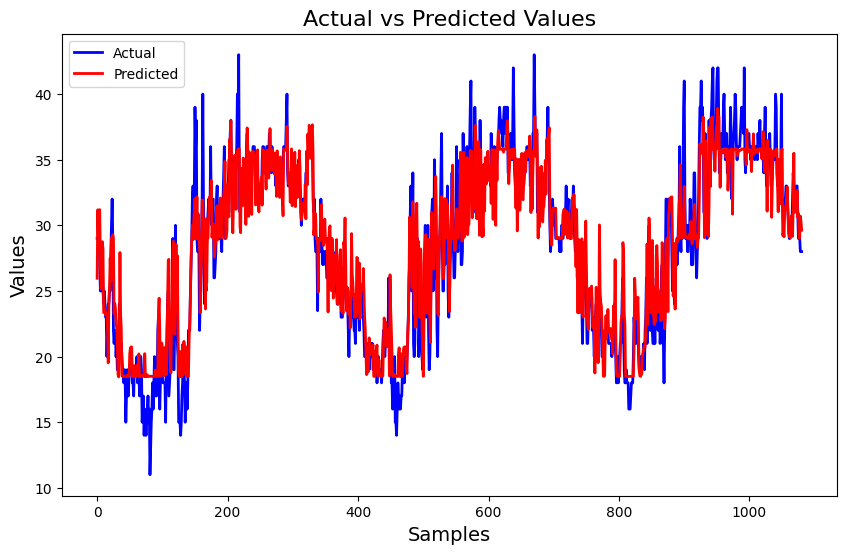

In [45]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(y_test, label='Actual', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(lstm_y_pred, label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Adding a legend
plt.legend()

# Display the plot
plt.show()